# Capstone Project - The Battle of the Neighborhoods

### Applied Data Science Capstone by IBM/Coursera

* **Name: Boyan Botev**

* **Date: 4/24/2019**

## Table of contents
* [Introduction/Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction/Business Problem <a name="introduction"></a>

The City of Charlotte has experienced a lot of growth in population, construction and business development in the recent years. In this paper I will perform segmentation analysis of the City of Charlotte, North Carolina for the purposes of understanding the composition of different venues near clusters of households with different characteristics. We'll examine clusters based on just two of several other possible metrics to gain better understanding of some of the charachteristics of the Queen city. 

The target audience for this report would be a business trying to find a location to open or relocate to or even the city of Charlotte which could incentivize certain businesses to come to neighborhoods where they would not typically go on their own for the purposes of creating greater diversity. 

## Data <a name="data"></a>

For this project I will be using data provided by the City fo Charlotte. The webite where the data resides is located at  http://data.charlottenc.gov/. I will be using two data sets from there, namely the Census Population Block Groups and the Census Household Income Block Groups. The first set  has the Longitude and Latitude of each Census Block Group and the second set contains demographic and income data for each block. A Census Block Group is defined as the smallest geographical unit for which the US Census Bureau publishes data. Typically, there are 600 to 3000 households per block group, but as we'll see later on this is not always the case.

In addition to the census location, demographic and income data described above, I will be collecting venues data using the Foursquare API and enriching the data set provided by the City of Charlotte. In this paper we'll mainly focus on the median income per Census Block Group, the population density per square mile and the venue category obtained by the Foursquare API.

#### First import libraries

In [1]:
import pandas as pd
import numpy as np
import json

from bs4 import BeautifulSoup
import requests

from geopy.geocoders import Nominatim 
import folium 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

mpl.style.use('ggplot')

In [2]:
%matplotlib inline 

#### Download the KML file showing the Census Block Groups and their locations from Charlotte Open Data portal:

http://data.charlottenc.gov/datasets/1d6040c72a5e4fee91e8fa1f8d1c5cc3_11/data

#### Download income data for each Census Block Group

http://data.charlottenc.gov/datasets/census-household-income-block-groups

### Preprocess the Census Block Groups. 
We'll need the Longitude and Latitude for each block and later join to the income data

In [3]:
with open('Census_Block_Groups.kml', 'r') as f:
    soup = BeautifulSoup(f, 'xml')

Extract the column names from the dataset 

In [4]:
s = ""
for sd in soup.find_all('SimpleField'):
    s = s + sd.attrs['name'] + ","
cols = s.split(",")
cols.pop()
print(cols)
print("Length: {}".format(len(cols)))

['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'GEOID10', 'NAMELSAD10', 'ALAND10', 'AWATER10', 'Latitude', 'Longitude', 'Population', 'White', 'African_American', 'AmerIn_AlaskaNative', 'Asian', 'NatHawaiian_PacIslander', 'Some_other_race', 'Two_or_more_races', 'Hispanic', 'Housing_Units', 'Occupied_Housing_Units', 'Vacant_Housing_Units', 'Occupancy_Rate', 'Percent_White', 'Percent_African_American', 'Percent_Asian', 'Percent_Hispanic', 'Pop_SqMi', 'SqMi', 'ShapeSTArea', 'ShapeSTLength']
Length: 32


Build empty frame

In [5]:
df = pd.DataFrame(columns=cols)
df

Empty DataFrame
Columns: [OBJECTID, STATEFP10, COUNTYFP10, TRACTCE10, BLKGRPCE10, GEOID10, NAMELSAD10, ALAND10, AWATER10, Latitude, Longitude, Population, White, African_American, AmerIn_AlaskaNative, Asian, NatHawaiian_PacIslander, Some_other_race, Two_or_more_races, Hispanic, Housing_Units, Occupied_Housing_Units, Vacant_Housing_Units, Occupancy_Rate, Percent_White, Percent_African_American, Percent_Asian, Percent_Hispanic, Pop_SqMi, SqMi, ShapeSTArea, ShapeSTLength]
Index: []

Let's put the data in the frame 

In [6]:
sd = soup.find_all('SimpleData')
i = 0

while i < len(sd):
    row = []
    for col in cols:
        #print(col)
        if i >= len(sd):
            row.append('0')
        elif col == sd[i].attrs['name']:
            row.append(sd[i].contents[0])
        else:
            row.append('0')
            i=i-1
        i=i+1
        
    df = df.append(pd.DataFrame([row],columns=cols),ignore_index=True)

In [7]:
df.head()

OBJECTID STATEFP10 COUNTYFP10 TRACTCE10 BLKGRPCE10       GEOID10  \
0        1        37        119    005301          1  371190053011   
1        2        37        119    001400          2  371190014002   
2        3        37        119    001200          3  371190012003   
3        4        37        119    005847          1  371190058471   
4        5        37        119    000700          1  371190007001   

      NAMELSAD10  ALAND10 AWATER10    Latitude    Longitude Population White  \
0  Block Group 1  3692032        0  35.2582845  -80.8060757       2622   503   
1  Block Group 2  1051009        0  35.2437169  -80.8024062       1290   982   
2  Block Group 3  2111630     6882   35.227408  -80.7930404       1674  1488   
3  Block Group 1  2937830    19993  35.0855266  -80.7642117       1194  1111   
4  Block Group 1  1271722        0   35.238594  -80.8190269        736   288   

  African_American AmerIn_AlaskaNative Asian NatHawaiian_PacIslander  \
0             1443                  19    73                       5   
1              204                   6    49                       0   
2              105                   7    32                       1   
3               15                   5    39                       0   
4              370                   1    60                       0   

  Some_other_race Two_or_more_races Hispanic Housing_Units  \
0             515                64      763          1155   
1              19                30       67           750   
2               5                36       60           829   
3               0                24       30           458   
4               3                14       19           443   

  Occupied_Housing_Units Vacant_Housing_Units Occupancy_Rate Percent_White  \
0                   1034                  121     0.89523809    0.19183829   
1                    645                  105           0.86    0.76124031   
2                    767                   62     0.92521109    0.88888888   
3                    431                   27     0.94104803    0.93048576   
4                    373                   70     0.84198645    0.39130434   

  Percent_African_American Percent_Asian Percent_Hispanic       Pop_SqMi  \
0               0.55034324    0.02784134       0.29099923  1839.82774992   
1               0.15813953    0.03798449       0.05193798  3179.74748584   
2               0.06272401    0.01911589       0.03584229  2047.08445784   
3               0.01256281    0.03266331       0.02512562  1045.77652705   
4               0.50271739    0.08152173       0.02581521  1499.32745237   

         SqMi       ShapeSTArea     ShapeSTLength  
0  1.42513341  39730439.0307617  27948.1327747263  
1  0.40569259  11310060.2045898  17806.0105455178  
2  0.81774838  22797516.5803833  22242.7348192012  
3  1.14173532  31829754.0740967  24818.7360669474  
4  0.49088676   13685137.831604   23242.269832404

In [8]:
df.shape

(555, 32)

Drop unnecessary columns

In [9]:
df.drop(['OBJECTID','STATEFP10','COUNTYFP10','TRACTCE10','BLKGRPCE10','NAMELSAD10','ALAND10','AWATER10','ShapeSTArea','ShapeSTLength'], axis=1, inplace=True)

In [10]:
df

GEOID10    Latitude    Longitude Population White African_American  \
0    371190053011  35.2582845  -80.8060757       2622   503             1443   
1    371190014002  35.2437169  -80.8024062       1290   982              204   
2    371190012003   35.227408  -80.7930404       1674  1488              105   
3    371190058471  35.0855266  -80.7642117       1194  1111               15   
4    371190007001   35.238594  -80.8190269        736   288              370   
5    371190001001  35.2255892  -80.8490392        334   285               29   
6    371190025002   35.218428  -80.8258117        665   584               53   
7    371190020035    35.15328  -80.7525771       1100   487              495   
8    371190057091  35.1279682  -80.6947191       1506  1218              123   
9    371190019182  35.1964659  -80.7552813       1725   523              916   
10   371190032011  35.1888304  -80.8695642       1129   692               69   
11   371190031021  35.1507457  -80.8551112       1761  1421              211   
12   371190058172  35.0697703  -80.7810902       2829  2506              115   
13   371190057151  35.2089774  -80.5900111       2526  2285               94   
14   371190056211  35.2473186  -80.6459136       2980  1770              946   
15   371190057162  35.1708129  -80.7158804       2656  1213              881   
16   371190018013  35.2070456  -80.7936017        587   237              297   
17   371190022003  35.1761471  -80.8064703        946   915               17   
18   371190058171  35.0811971  -80.7791622       1172  1068               35   
19   371190037002  35.2030473  -80.8760992       1204    29             1119   
20   371190030061   35.138038  -80.8295891       1599  1531               22   
21   371190058313   35.085079  -80.8493397        317   262               35   
22   371190022004  35.1831936  -80.8126767       1662  1505               87   
23   371190055242  35.3114081  -80.7846415       1259   215              385   
24   371190060062  35.2725518  -80.9585192       1787   680              882   
25   371190062092  35.4476273  -80.8877246       1500  1259              150   
26   371190062091  35.4587443  -80.8805861        464   419               26   
27   371190062093  35.4505892  -80.8757168       1862  1629              124   
28   371190058332  35.1060535  -80.7405792       2478  2208               60   
29   371190059061  35.2367769  -81.0013011       1657  1113              340   
30   371190014001  35.2488617  -80.7906553       1317   652              537   
31   371190058111  35.1387751  -80.7540655       2268  1896              193   
32   371190057121  35.1238872  -80.6840065       2089  1807              146   
33   371190006002  35.2205413  -80.8362913       3260  1235             1874   
34   371190008001   35.229557  -80.8179051       1696   191             1355   
35   371190057122  35.1204416   -80.671003       1547  1353               98   
36   371190055081  35.3561915   -80.826062       2319  1626              509   
37   371190015081   35.249827  -80.7271767       2494   821             1195   
38   371190015041   35.247201   -80.770998       2868   461             1738   
39   371190013001   35.240376  -80.7822605       2339   859             1255   
40   371190058301  35.0782492  -80.8596673       1442  1146              163   
41   371190027012  35.2036999  -80.8284125       1064   966               70   
42   371190031052   35.124407    -80.85753       2057  1853               90   
43   371190030062  35.1285569  -80.8308377       2331  2027              172   
44   371190030074  35.1251088  -80.8216801       1410  1196              106   
45   371190057131  35.1503021  -80.6578001       1627  1407              110   
46   371190027011  35.1951902  -80.8310585        655   634                5   
47   371190021001  35.1903317  -80.7897279        640   337              226   
48   371190030114  35.1232565   -80.836786        819   635               83   
49   37119

### Now Preprocess the Census Household Income Block Groups. 

In [11]:
with open('Census_Household_Income_Block_Groups.kml', 'r') as f:
    soup = BeautifulSoup(f, 'xml')

In [12]:
s = ""
for sd in soup.find_all('SimpleField'):
    s = s + sd.attrs['name'] + ","
cols = s.split(",")
cols.pop()
print(cols)
print("Length: {}".format(len(cols)))

['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'GEOID10', 'NAMELSAD10', 'LOGRECNO', 'geoname', 'Total_Households', 'Less_than_10000', 'i10000_to_14999', 'i15000_to19999', 'i20000_to_24999', 'i25000_to_29999', 'i30000_to_34999', 'i35000_to_39999', 'i40000_to_44999', 'i45000_to_49999', 'i50000_to_59999', 'i60000_to_74999', 'i75000_to_99999', 'i100000_to_124999', 'i125000_to_149999', 'i150000_to_199999', 'i200000_or_more', 'Median_Household_Income', 'TotalFamilies', 'FamiliesInPoverty', 'FamilyPovertyRate', 'SHAPESTArea', 'SHAPESTLength']
Length: 32


In [13]:
df_income = pd.DataFrame(columns=cols)

In [14]:
sd = soup.find_all('SimpleData')
i = 0

while i < len(sd):
    row = []
    for col in cols:
        #print(col)
        if i >= len(sd):
            row.append('0')                 # we'll assume 0 for missing data 
        elif col == sd[i].attrs['name']:
            row.append(sd[i].contents[0])
        else:
            row.append('0')                 # we'll assume 0 for missing data
            i=i-1
        i=i+1
        
    df_income = df_income.append(pd.DataFrame([row],columns=cols),ignore_index=True)

In [15]:
df_income.drop(['OBJECTID','STATEFP10','COUNTYFP10','TRACTCE10','BLKGRPCE10','NAMELSAD10','SHAPESTArea','SHAPESTLength','LOGRECNO'], axis=1, inplace=True)
df_income

GEOID10                                            geoname  \
0    371190035001  Block Group 1, Census Tract 35, Mecklenburg Co...   
1    371190040003  Block Group 3, Census Tract 40, Mecklenburg Co...   
2    371190059071  Block Group 1, Census Tract 59.07, Mecklenburg...   
3    371190057111  Block Group 1, Census Tract 57.11, Mecklenburg...   
4    371190048002  Block Group 2, Census Tract 48, Mecklenburg Co...   
5    371190058481  Block Group 1, Census Tract 58.48, Mecklenburg...   
6    371190015091  Block Group 1, Census Tract 15.09, Mecklenburg...   
7    371190056181  Block Group 1, Census Tract 56.18, Mecklenburg...   
8    371190018013  Block Group 3, Census Tract 18.01, Mecklenburg...   
9    371190015042  Block Group 2, Census Tract 15.04, Mecklenburg...   
10   371190060062  Block Group 2, Census Tract 60.06, Mecklenburg...   
11   371190006001  Block Group 1, Census Tract 6, Mecklenburg Cou...   
12   371190020021  Block Group 1, Census Tract 20.02, Mecklenburg...   
13   371190055092  Block Group 2, Census Tract 55.09, Mecklenburg...   
14   371190029052  Block Group 2, Census Tract 29.05, Mecklenburg...   
15   371190031021  Block Group 1, Census Tract 31.02, Mecklenburg...   
16   371190016092  Block Group 2, Census Tract 16.09, Mecklenburg...   
17   371190031091  Block Group 1, Census Tract 31.09, Mecklenburg...   
18   371190064052  Block Group 2, Census Tract 64.05, Mecklenburg...   
19   371190027021  Block Group 1, Census Tract 27.02, Mecklenburg...   
20   371190030131  Block Group 1, Census Tract 30.13, Mecklenburg...   
21   371190001004  Block Group 4, Census Tract 1, Mecklenburg Cou...   
22   371190058151  Block Group 1, Census Tract 58.15, Mecklenburg...   
23   371190040001  Block Group 1, Census Tract 40, Mecklenburg Co...   
24   371190057131  Block Group 1, Census Tract 57.13, Mecklenburg...   
25   371190019211  Block Group 1, Census Tract 19.21, Mecklenburg...   
26   371190038072  Block Group 2, Census Tract 38.07, Mecklenburg...   
27   371190058313  Block Group 3, Census Tract 58.31, Mecklenburg...   
28   371190061091  Block Group 1, Census Tract 61.09, Mecklenburg...   
29   371190057132  Block Group 2, Census Tract 57.13, Mecklenburg...   
30   371190062044  Block Group 4, Census Tract 62.04, Mecklenburg...   
31   371190055151  Block Group 1, Census Tract 55.15, Mecklenburg...   
32   371190029051  Block Group 1, Census Tract 29.05, Mecklenburg...   
33   371190058291  Block Group 1, Census Tract 58.29, Mecklenburg...   
34   371190064063  Block Group 3, Census Tract 64.06, Mecklenburg...   
35   371190058432  Block Group 2, Census Tract 58.43, Mecklenburg...   
36   371190056122  Block Group 2, Census Tract 56.12, Mecklenburg...   
37   371190032042  Block Group 2, Census Tract 32.04, Mecklenburg...   
38   371190042004  Block Group 4, Census Tract 42, Mecklenburg Co...   
39   371190046001  Block Group 1, Census Tract 46, Mecklenburg Co...   
40   371190030074  Block Group 4, Census Tract 30.07, Mecklenburg...   
41   371190058472  Block Group 2, Census Tract 58.47, Mecklenburg...   
42   371190022003  Block Group 3, Census Tract 22, Mecklenburg Co...   
43   371190030072  Block Group 2, Census Tract 30.07, Mecklenburg...   
44   371190029043  Block Group 3, Census Tract 29.04, Mecklenburg...   
45   371190057113  Block Group 3, Census Tract 57.11, Mecklenburg...   
46   371190063042  Block Group 2, Census Tract 63.04, Mecklenburg...   
47   371190030181  Block Group 1, Census Tract 30.18, Mecklenburg...   
48   371190030083  Block Group 3, Census Tract 30.08, Mecklenburg...   
49   371190056041  Block Group 1, Census Tract 56.04, Mecklenburg...   
50   371190057064  Block Group 4, Census Tract 57.06, Mecklenburg...   
51   371190001005  Block Group 5, Census Tract 1, Mecklenburg Cou...   
52   371190058311  Block Group 1, Census Tract 58.31, Mecklenburg...   
53   371190036003  Block Group 3, Census Tract 36, Mecklenburg Co...   
54   371190062141  Block Group 1, Census Tract 62.

### Build the final combined set of all Census data which we'll use

In [16]:
df_combined = df_income.merge(df,on='GEOID10')

In [17]:
df_combined

GEOID10                                            geoname  \
0    371190035001  Block Group 1, Census Tract 35, Mecklenburg Co...   
1    371190040003  Block Group 3, Census Tract 40, Mecklenburg Co...   
2    371190059071  Block Group 1, Census Tract 59.07, Mecklenburg...   
3    371190057111  Block Group 1, Census Tract 57.11, Mecklenburg...   
4    371190048002  Block Group 2, Census Tract 48, Mecklenburg Co...   
5    371190058481  Block Group 1, Census Tract 58.48, Mecklenburg...   
6    371190015091  Block Group 1, Census Tract 15.09, Mecklenburg...   
7    371190056181  Block Group 1, Census Tract 56.18, Mecklenburg...   
8    371190018013  Block Group 3, Census Tract 18.01, Mecklenburg...   
9    371190015042  Block Group 2, Census Tract 15.04, Mecklenburg...   
10   371190060062  Block Group 2, Census Tract 60.06, Mecklenburg...   
11   371190006001  Block Group 1, Census Tract 6, Mecklenburg Cou...   
12   371190020021  Block Group 1, Census Tract 20.02, Mecklenburg...   
13   371190055092  Block Group 2, Census Tract 55.09, Mecklenburg...   
14   371190029052  Block Group 2, Census Tract 29.05, Mecklenburg...   
15   371190031021  Block Group 1, Census Tract 31.02, Mecklenburg...   
16   371190016092  Block Group 2, Census Tract 16.09, Mecklenburg...   
17   371190031091  Block Group 1, Census Tract 31.09, Mecklenburg...   
18   371190064052  Block Group 2, Census Tract 64.05, Mecklenburg...   
19   371190027021  Block Group 1, Census Tract 27.02, Mecklenburg...   
20   371190030131  Block Group 1, Census Tract 30.13, Mecklenburg...   
21   371190001004  Block Group 4, Census Tract 1, Mecklenburg Cou...   
22   371190058151  Block Group 1, Census Tract 58.15, Mecklenburg...   
23   371190040001  Block Group 1, Census Tract 40, Mecklenburg Co...   
24   371190057131  Block Group 1, Census Tract 57.13, Mecklenburg...   
25   371190019211  Block Group 1, Census Tract 19.21, Mecklenburg...   
26   371190038072  Block Group 2, Census Tract 38.07, Mecklenburg...   
27   371190058313  Block Group 3, Census Tract 58.31, Mecklenburg...   
28   371190061091  Block Group 1, Census Tract 61.09, Mecklenburg...   
29   371190057132  Block Group 2, Census Tract 57.13, Mecklenburg...   
30   371190062044  Block Group 4, Census Tract 62.04, Mecklenburg...   
31   371190055151  Block Group 1, Census Tract 55.15, Mecklenburg...   
32   371190029051  Block Group 1, Census Tract 29.05, Mecklenburg...   
33   371190058291  Block Group 1, Census Tract 58.29, Mecklenburg...   
34   371190064063  Block Group 3, Census Tract 64.06, Mecklenburg...   
35   371190058432  Block Group 2, Census Tract 58.43, Mecklenburg...   
36   371190056122  Block Group 2, Census Tract 56.12, Mecklenburg...   
37   371190032042  Block Group 2, Census Tract 32.04, Mecklenburg...   
38   371190042004  Block Group 4, Census Tract 42, Mecklenburg Co...   
39   371190046001  Block Group 1, Census Tract 46, Mecklenburg Co...   
40   371190030074  Block Group 4, Census Tract 30.07, Mecklenburg...   
41   371190058472  Block Group 2, Census Tract 58.47, Mecklenburg...   
42   371190022003  Block Group 3, Census Tract 22, Mecklenburg Co...   
43   371190030072  Block Group 2, Census Tract 30.07, Mecklenburg...   
44   371190029043  Block Group 3, Census Tract 29.04, Mecklenburg...   
45   371190057113  Block Group 3, Census Tract 57.11, Mecklenburg...   
46   371190063042  Block Group 2, Census Tract 63.04, Mecklenburg...   
47   371190030181  Block Group 1, Census Tract 30.18, Mecklenburg...   
48   371190030083  Block Group 3, Census Tract 30.08, Mecklenburg...   
49   371190056041  Block Group 1, Census Tract 56.04, Mecklenburg...   
50   371190057064  Block Group 4, Census Tract 57.06, Mecklenburg...   
51   371190001005  Block Group 5, Census Tract 1, Mecklenburg Cou...   
52   371190058311  Block Group 1, Census Tract 58.31, Mecklenburg...   
53   371190036003  Block Group 3, Census Tract 36, Mecklenburg Co...   
54   371190062141  Block Group 1, Census Tract 62.

Convert numeric datatypes to float for later processing

In [18]:
cols = ['Total_Households', 'Less_than_10000', 'i10000_to_14999', 'i15000_to19999', 'i20000_to_24999', 'i25000_to_29999', 'i30000_to_34999', 'i35000_to_39999', 'i40000_to_44999', 'i45000_to_49999', 'i50000_to_59999', 'i60000_to_74999', 'i75000_to_99999', 'i100000_to_124999', 'i125000_to_149999', 'i150000_to_199999', 'i200000_or_more', 'Median_Household_Income', 'TotalFamilies', 'FamiliesInPoverty', 'FamilyPovertyRate','Latitude', 'Longitude', 'Population', 'White', 'African_American', 'AmerIn_AlaskaNative', 'Asian', 'NatHawaiian_PacIslander', 'Some_other_race', 'Two_or_more_races', 'Hispanic', 'Housing_Units', 'Occupied_Housing_Units', 'Vacant_Housing_Units', 'Occupancy_Rate', 'Percent_White', 'Percent_African_American', 'Percent_Asian', 'Percent_Hispanic', 'Pop_SqMi', 'SqMi']
for c in cols:
    df_combined[c] = df_combined[c].astype(float)

Remove areas without households

In [19]:
df_combined = df_combined[df_combined['Total_Households'] != 0]

### Let's Visualize and Explore Data

In [20]:
address = 'Charlotte, NC'

geolocator = Nominatim(user_agent="cha_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Charlotte: {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Charlotte: 35.2270869, -80.8431268.


### Visualize the different Census Block Groups in Charlotte

In [21]:
# create map of Charlotte using latitude and longitude values
map_charlotte = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, geoname in zip(df_combined['Latitude'], df_combined['Longitude'], df_combined['geoname']):
    label = '{}'.format(geoname)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_charlotte)  
    
map_charlotte

![Charlotte Map](img/m1.png)

### Let's Cluster the data by Median Income

In [22]:
# set number of clusters
kclusters = 3

df_med_income = df_combined['Median_Household_Income'].to_frame()

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(df_med_income)

In [23]:
kmeans.labels_

array([0, 2, 1, 0, 2, 1, 2, 0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 0, 1, 0, 2,
       0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 2, 0, 2, 0, 0, 2,
       1, 0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 0, 2,
       0, 2, 2, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0,
       2, 0, 2, 2, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 2, 1, 0, 1,
       0, 2, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 0, 2, 2, 1, 2, 1, 1, 2, 0, 2,
       2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 2, 2, 1, 2, 0, 0, 2,
       2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 1, 2,
       2, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 1, 1, 0, 2,
       1, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2,

In [24]:
df_combined.insert(0,"Income Cluster Labels", kmeans.labels_)

In [25]:
df_combined

Income Cluster Labels       GEOID10  \
0                        0  371190035001   
1                        2  371190040003   
2                        1  371190059071   
3                        0  371190057111   
4                        2  371190048002   
5                        1  371190058481   
6                        2  371190015091   
7                        0  371190056181   
8                        2  371190018013   
9                        2  371190015042   
10                       2  371190060062   
11                       0  371190006001   
12                       0  371190020021   
13                       2  371190055092   
14                       1  371190029052   
15                       2  371190031021   
16                       2  371190016092   
17                       2  371190031091   
18                       0  371190064052   
19                       1  371190027021   
20                       0  371190030131   
21                       2  371190001004   
22                       0  371190058151   
23                       2  371190040001   
24                       0  371190057131   
25                       2  371190019211   
26                       2  371190038072   
27                       0  371190058313   
28                       2  371190061091   
29                       0  371190057132   
30                       2  371190062044   
31                       0  371190055151   
32                       1  371190029051   
33                       2  371190058291   
34                       0  371190064063   
35                       0  371190058432   
36                       0  371190056122   
37                       0  371190032042   
38                       2  371190042004   
39                       2  371190046001   
40                       0  371190030074   
41                       1  371190058472   
42                       0  371190022003   
43                       1  371190030072   
44                       0  371190029043   
45                       0  371190057113   
46                       1  371190063042   
47                       0  371190030181   
48                       0  371190030083   
49                       2  371190056041   
50                       0  371190057064   
51                       0  371190001005   
52                       0  371190058311   
53                       2  371190036003   
54                       0  371190062141   
55                       0  371190055202   
56                       2  371190023001   
57                       1  371190029041   
58                       0  371190030113   
59                       2  371190058301   
60                       2  371190062032   
61                       0  371190031051   
62                       2  371190040002   
63                       0  371190064051   
64                       0  371190057151   
65                       2  371190059063   
66                       1  371190058483   
67                       0  371190020023   
68                       2  371190019151   
69                       2  371190053081   
70                       2  371190053062   
71                       1  371190030112   
72                       0  371190041002   
73                       0  371190056201   
74                       0  371190029063   
75                       0  371190060092   
76                       2  371190016071   
77                       2  371190056102   
78                       1  371190058161   
79                       2  371190031081   
80                       2  371190030082   
81                       1  371190022002   
82                       1  371190058374   
83                       2  371190019193   
84                       2  371190043051   
85                       2  371190030081   
86                       2  371190019122   
87                       2  371190019183   
89                       2  371190044002   
90                       2  371190031033   
9

Let's see how the clusters look on the map

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,mi in zip(df_combined['Latitude'], df_combined['Longitude'], df_combined['geoname'], df_combined['Income Cluster Labels'], df_combined['Median_Household_Income']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Median Income ' + str(mi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters

In [27]:
map_clusters

![Charlotte Map](img/m2.png)

Let's see the average income per cluster.

Text(0.5, 1.0, 'Average of Median Household Income per cluster')

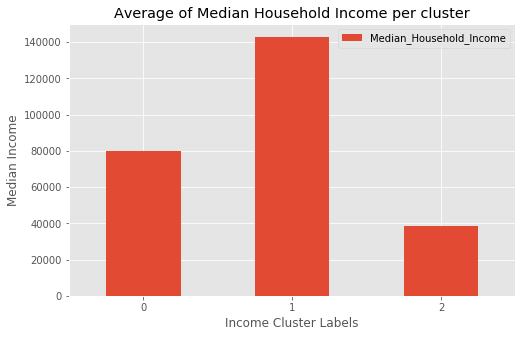

In [28]:
cluster_avg = df_combined.groupby(['Income Cluster Labels']).mean()
ax = cluster_avg.plot(kind='bar',y=['Median_Household_Income'],rot=0,figsize=(8,5))
ax.set_ylabel('Median Income')
ax.set_title('Average of Median Household Income per cluster')

### Let's also Cluster the data by density of the population i.e. population per square mile

In [29]:
# set number of clusters
kclusters = 3

df_pop_density = df_combined['Pop_SqMi'].to_frame()

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(df_pop_density)

In [30]:
kmeans.labels_

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,

In [31]:
df_combined.insert(0,"PopDensity Cluster Labels", kmeans.labels_)

Let's look at the density of population on the map

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, popd in zip(df_combined['Latitude'], df_combined['Longitude'], df_combined['geoname'], df_combined['PopDensity Cluster Labels'], df_combined['Pop_SqMi']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Pop Density ' + str(popd), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters

In [33]:
map_clusters

![Charlotte Map](img/m3.png)

Let's see the average population density per cluster.

Text(0.5, 1.0, 'Average population density per cluster')

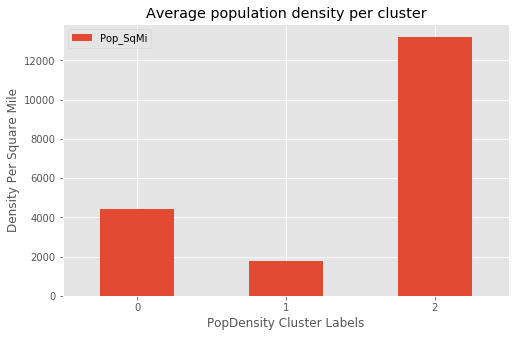

In [34]:
cluster_avg = df_combined.groupby(['PopDensity Cluster Labels']).mean()
ax = cluster_avg.plot(kind='bar',y=['Pop_SqMi'],rot=0,figsize=(8,5))
ax.set_ylabel('Density Per Square Mile')
ax.set_title('Average population density per cluster')

### Enrich data with Foursquare data

In [35]:
import os 

CLIENT_ID = os.environ['CLIENT_ID'] 
CLIENT_SECRET = os.environ['CLIENT_SECRET']
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['geoname', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Sometimes Foursquare API calls fail due to Rate limits. For repeatability I have a csv file with the same data.

In [37]:
# charlotte_venues = getNearbyVenues(names=df_combined['geoname'],
#                                    latitudes=df_combined['Latitude'],
#                                    longitudes=df_combined['Longitude']
#                                   )

If our Foursquare API calls fail to collect all the data due to Rate limits

In [44]:
charlotte_venues = pd.read_csv('charlotte_venues.csv',index_col=['Unnamed: 0'])

In [45]:
charlotte_venues.head()

geoname  Neighborhood Latitude  \
0  Block Group 1, Census Tract 35, Mecklenburg Co...              35.204552   
1  Block Group 1, Census Tract 35, Mecklenburg Co...              35.204552   
2  Block Group 1, Census Tract 35, Mecklenburg Co...              35.204552   
3  Block Group 1, Census Tract 35, Mecklenburg Co...              35.204552   
4  Block Group 1, Census Tract 35, Mecklenburg Co...              35.204552   

   Neighborhood Longitude             Venue  Venue Latitude  Venue Longitude  \
0              -80.841703       Duck Donuts       35.202624       -80.844419   
1              -80.841703       Bakersfield       35.202040       -80.844430   
2              -80.841703  Dolce Ristorante       35.202836       -80.844343   
3              -80.841703           Be Yoga       35.202610       -80.844875   
4              -80.841703     Harris Teeter       35.203562       -80.845130   

       Venue Category  
0              Bakery  
1  Mexican Restaurant  
2  Italian Restaurant  
3         Yoga Studio  
4         Supermarket

## Methodology <a name="methodology"></a>

The first step of our methodology was to collect location, demographic, income and venues data for the City of Charlotte. We have collected and preprocessed the data as a first step. We'll segment the data set two different ways by Kmeans clustering. The first clustering method will be by Household Median income and the second will be based on population density per Census block i.e. population per square mile. Afterwards we'll use the clusters to create Wordclouds of the venues categories by cluster. This will show us what kind of venues are near each type of population area and help us gain better understanding about the City of Charlotte.  

## Analysis <a name="analysis"></a>

Let's create a wordcloud for the clusters to easily visualize the popularity of venues per cluster

In [46]:
from wordcloud import WordCloud, STOPWORDS

### Let's look at the venues per income cluster

In [47]:
charlotte_merged = charlotte_venues.merge(df_combined[['Income Cluster Labels','geoname']],on=['geoname'])

In [48]:
stopwords = set(STOPWORDS)
#stopwords.add("Restaurant")

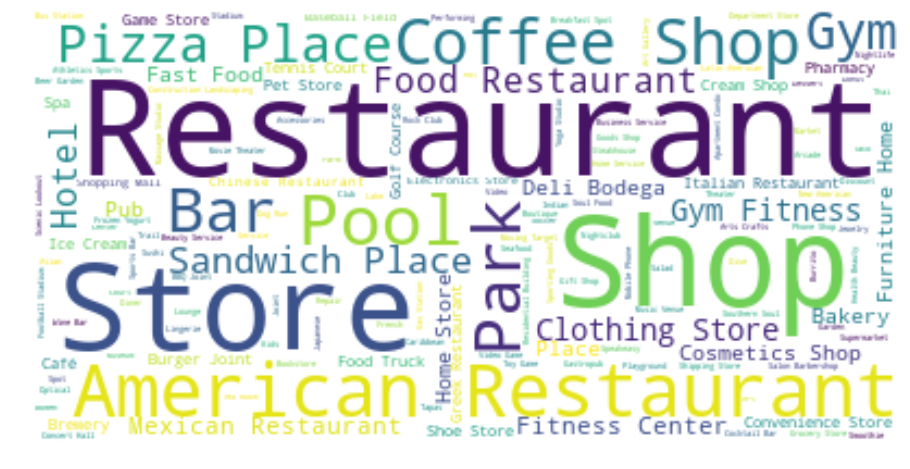

In [49]:
c0 = charlotte_merged[charlotte_merged['Income Cluster Labels'] == 0]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c0))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

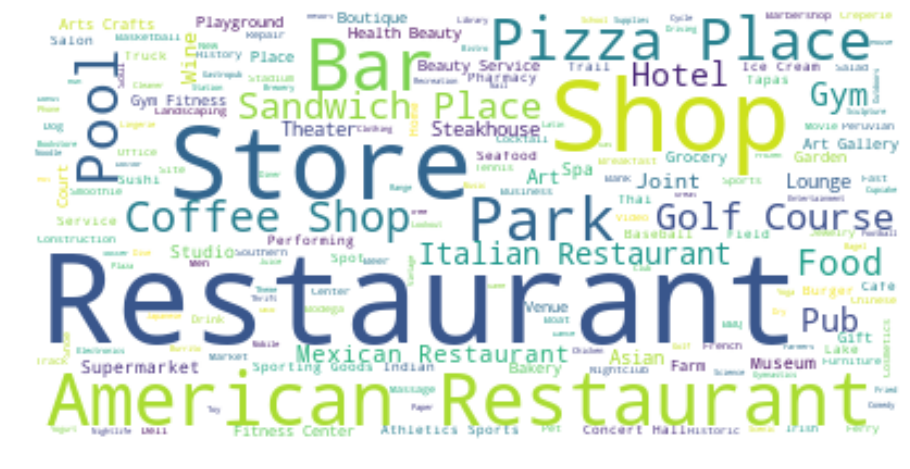

In [50]:
c1 = charlotte_merged[charlotte_merged['Income Cluster Labels'] == 1]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c1))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

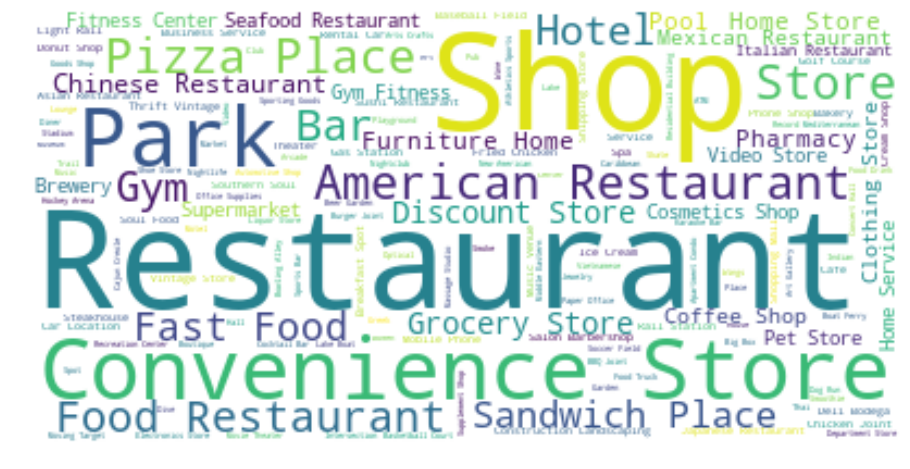

In [51]:
c2 = charlotte_merged[charlotte_merged['Income Cluster Labels'] == 2]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c2))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Let's look at the data for each Population Density Cluster

In [52]:
charlotte_merged = charlotte_venues.merge(df_combined[['PopDensity Cluster Labels','geoname']],on=['geoname'])

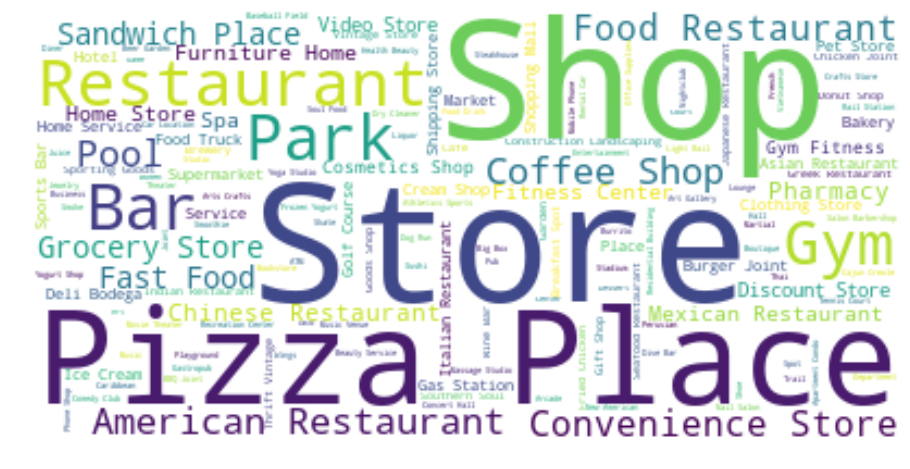

In [53]:
c0 = charlotte_merged[charlotte_merged['PopDensity Cluster Labels'] == 0]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c0))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

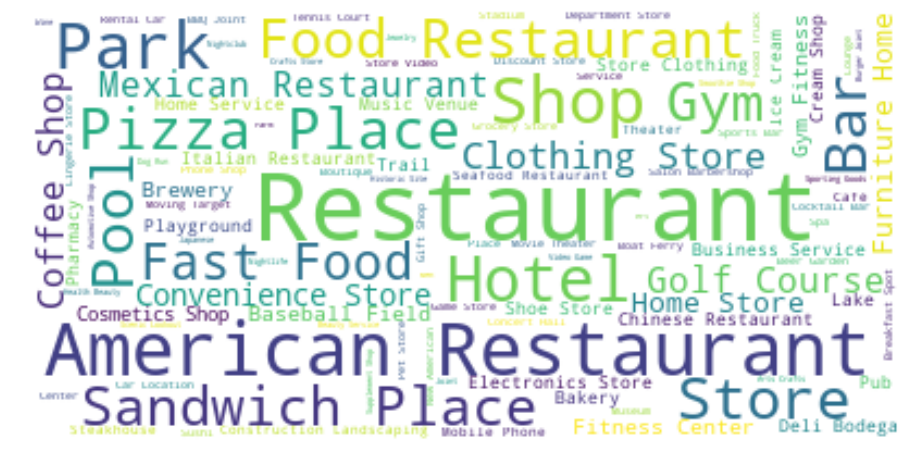

In [54]:
c1 = charlotte_merged[charlotte_merged['PopDensity Cluster Labels'] == 1]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c1))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

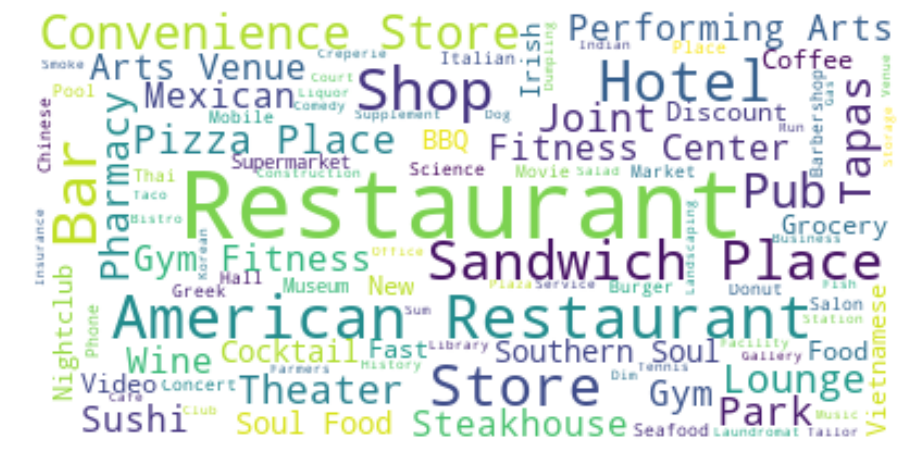

In [55]:
c2 = charlotte_merged[charlotte_merged['PopDensity Cluster Labels'] == 2]['Venue Category'].values
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(" ".join(c2))
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Results <a name="results"></a>

We were able to segment the City of Charlotte into 3 clusters by income and population density. We observe the following trends based on each clustering method:

**Income Clusters**

1. Cluster Label 0 - Households with average income of 80,000. This is probably what we may call "Middle Income". We see that the venues near this group feature American and other Restaurants, Shopping, Stores, Coffee shops, Bar, Parks, Pools and Gyms.


2. Cluster Label 1 - Households with average income of above 140,000. We'll call this group "Upper Income". We see that the venues near this cluster group feature similar venues as Cluster 1, but we also see that we have Gold Courses near those households


3. Cluster Label 2 - Household with average income of 40,000. We'll call this group "Lower Income". We see that Restaurants are still prominent, but American Restaurants are not as popular there. We see a lot of Convenience stores, Shopping and Parks, but also Fast Food places. 



**Population Density Clusters**

1. Cluster Label 0 - Medium Population Density with an average of around 4,000 per square mile. We see a very strong trend for Shops, Stores and Pizza Places and fewer other venues comparitively.


2. Cluster Label 1 - Low Population Density with an average of less than 2,000 per square mile. There is a better mix of venues in this cluster featuring Restaurants, Shopping, Hotels, Sandwitch Places, Fast Food and Parks.


3. Cluster Label 2 - High Population Density with an average of close to 13,000 per square mile. This group features a lot more venues which we have not seen previously like Performing Arts, Theatre, Soul food, Arts Venue in addition to what we have learned to expect i.e. Restaurants and Shops. 


## Conclusion <a name="conclusion"></a>

Our investigation in the City of Charlotte revealed some interesting, but probably expected results. We can find American Restaurants almost anywhere in the city. Other Restaurants and Shopping is also easy to come by. We find more Fast Food places and Convenience Stores compared to other venues in lower income areas of the city. We also do see the highest variety of venues and entertainment in the very high population density areas of the city i.e. downtown. 

This notebook shows just 2 of the clustering methods, but many more are possible with the available information.